In [2]:
# References: https://www.kaggle.com/code/wangsg/a-self-attentive-model-for-knowledge-tracing/notebook

# Self-Attention Model simple

In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype


DATA_DIR = '../mlbd-2023/data/'

users = pd.read_csv('{}/small_users.csv'.format(DATA_DIR), index_col=0)
events = pd.read_csv('{}/small_events.csv'.format(DATA_DIR), index_col=0)
subtasks = pd.read_csv('{}/small_subtasks.csv'.format(DATA_DIR), index_col=0)


In [5]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import math

In [25]:
import gc
import random
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


## Create time series
- Create column "week_sequential" -> Normalize dates to start at 1 for every student
- Join events and subtasks on event_id. Ignore subtasks not tied to an event


In [6]:
events[['Year', 'Week', 'Day']] = pd.to_datetime(events['start']).dt.isocalendar()
events['year_week'] = ((events['Year'] - 2015) * 53 + events['Week']).astype(int)
ts = events.reset_index().groupby(['user_id','year_week'])['event_id'].count().reset_index()
ts.rename(columns={'event_id':'num_events'}, inplace=True)

In [7]:
print(len(set(events.reset_index().event_id.unique()) - set(subtasks.event_id.unique())))
print("Some events have no subtasks")
print(len(set(subtasks.event_id.unique()) - set(events.reset_index().event_id.unique())))
print("There are no subtasks which don't correspond to an event")
print("We don't care about subtasks which don't have a coresponding event_id because we don't know what skill they are for")

427
Some events have no subtasks
0
There are no subtasks which don't correspond to an event
We don't care about subtasks which don't have a coresponding event_id because we don't know what skill they are for


In [8]:
events_and_substasks = events.reset_index().merge(subtasks.reset_index(), how='left', on=['event_id','user_id'], suffixes=('_event', '_subtask'))
events_and_substasks['date'] = pd.to_datetime(events_and_substasks['start'])
events_and_substasks[['Year', 'Week', 'Day']] = events_and_substasks['date'].dt.isocalendar()
events_and_substasks['year_week'] = (events_and_substasks['Year'] - 2015) * 53 + events_and_substasks['Week']
events_and_substasks['week_sequential'] = events_and_substasks.groupby('user_id')['year_week'].apply(lambda x: x - x.iat[0])

In [9]:
task_events = events_and_substasks.query('type_event == "task" & correct != "nan"')

## Feature Selection
- Ignore categorical features with nulls for now

In [10]:
index = ['event_id','user_id']
cat_features = ['mode_event', 'game_name','number_range','skill_id', 'type_subtask']
cat_features_withnulls = [ 'destination', 'multiplier','operator','representation', 'solutionRepresentation', 'solveMode']
date_features = ['date','Year', 'Week', 'Day','week_sequential']
target_feature = ['correct']

In [11]:
df = task_events[index + cat_features + date_features + target_feature]

## Feature Engineering
- Create column "cumulative_percent_correct" - a feature for each student on their percentage correct so far (no data leakage from the future!)

In [12]:
df = df.sort_values(by='date')

In [13]:
# Create a feature that represents the student's overall cumulative accuracy per skill
cumulative_percent_correct = df.groupby(['user_id','skill_id'],sort=False)['correct'].expanding(1).mean().reset_index().drop(columns=['user_id','skill_id']).rename(columns={'correct':'cumulative_percent_correct'})

In [14]:
df = df.merge(cumulative_percent_correct, left_index=True, right_on='level_2', how='left')

In [15]:
# Create a feature that represents the student's accuracy over the last 30 days per skill
# window_size = 30
# df_roll = df.groupby(['user_id','skill_id'])['correct'].rolling(window_size).mean()

# Other ideas:
# Num Questions answered so far
# percent correct on skill type by all players so far

In [16]:
df

,event_id,user_id,mode_event,game_name,number_range,skill_id,type_subtask,date,Year,Week,Day,week_sequential,correct,level_2,cumulative_percent_correct
0,118,7,NORMAL,Subitizing,R10,1.0,ConciseTimeoutDescription,2015-03-19 18:48:57.303000+00:00,2015,12,4,0,True,135,1.000000
1,118,7,NORMAL,Subitizing,R10,1.0,ConciseSubitizingTaskDescription,2015-03-19 18:48:57.303000+00:00,2015,12,4,0,True,134,1.000000
2,119,7,NORMAL,Conversion,R10,3.0,ConciseConversionTaskDescription,2015-03-20 18:07:17.288000+00:00,2015,12,5,0,True,136,1.000000
3,120,7,NORMAL,Landing,R10,19.0,ConciseLandingTaskDescription,2015-03-23 15:18:26.515000+00:00,2015,13,1,1,True,137,1.000000
4,121,7,END_OF_NR,Conversion,R10,7.0,ConciseConversionTaskDescription,2015-04-02 14:03:06.836000+00:00,2015,14,4,2,True,138,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53429,24597,644,END_OF_NR,Secret Number,R100,107.0,ConciseNumberInIntervalTaskDescription,2023-02-11 13:04:38.328000+00:00,2023,6,6,20,True,36904,0.777778
53430,24597,644,END_OF_NR,Secret Number,R100,107.0,ConciseNumberInIntervalTaskDescription,2023-02-11 13:04:38.328000+00:00,2023,6,6,20,True,36903,0.789474
53431,24597,644,END_OF_NR,Secret Number,R100,107.0,ConciseNumberInIntervalTaskDescription,2023-02-11 13:04:38.328000+00:00,2023,6,6,20,True,36907,0.800000
54399,12966,318,END_OF_NR,Distance,R100,105.0,ConciseOrdinalityTaskDescription,2023-02-12 09:08:57.789000+00:00,2023,6,7,14,False,19918,0.000000


In [17]:
# Check there are no nans
df.isna().sum()

event_id                      0
user_id                       0
mode_event                    0
game_name                     0
number_range                  0
skill_id                      0
type_subtask                  0
date                          0
Year                          0
Week                          0
Day                           0
week_sequential               0
correct                       0
level_2                       0
cumulative_percent_correct    0
dtype: int64

In [18]:
# LGBM only accepts int, bool and float
for col in cat_features:
    # Convert categories into ints
    df[col] = df[col].astype('category')
df['week_sequential'] = df['week_sequential'].astype('int32')
df[target_feature] = df[target_feature].astype('bool')

## Dataset creation


In [20]:
df = df.sort_values(['date'], ascending=True).reset_index(drop = True)


In [21]:
skills = df["skill_id"].unique()
n_skill = len(skills)
print("number skills", len(skills))

number skills 210


In [39]:
max(skills)

250.0

In [22]:
group = df[['user_id', 'skill_id', 'correct']].groupby('user_id').apply(lambda r: (
            r['skill_id'].values,
            r['correct'].values))

In [27]:
class SAKTDataset(Dataset):
    def __init__(self, group, n_skill, max_seq=100):
        super(SAKTDataset, self).__init__()
        self.max_seq = max_seq
        self.n_skill = n_skill
        self.samples = group
        
        self.user_ids = []
        for user_id in group.index:
            q, qa = group[user_id]
            if len(q) < 10:
                continue
            self.user_ids.append(user_id)

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, index):
        user_id = self.user_ids[index]
        q_, qa_ = self.samples[user_id]
        seq_len = len(q_)

        q = np.zeros(self.max_seq, dtype=int)
        qa = np.zeros(self.max_seq, dtype=int)
        if seq_len >= self.max_seq:
            q[:] = q_[-self.max_seq:]
            qa[:] = qa_[-self.max_seq:]
        else:
            q[-seq_len:] = q_
            qa[-seq_len:] = qa_
        
        target_id = q[1:]
        label = qa[1:]

        x = np.zeros(self.max_seq-1, dtype=int)
        x = q[:-1].copy()
        x += (qa[:-1] == 1) * self.n_skill

        return x, target_id, label

In [28]:
train, val = train_test_split(group, test_size=0.2)

train_dataset = SAKTDataset(train, n_skill)
train_dataloader = DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=8)
del train

val_dataset = SAKTDataset(val, n_skill)
val_dataloader = DataLoader(val_dataset, batch_size=2048, shuffle=True, num_workers=8)
del val

## Build Model

In [29]:
class FFN(nn.Module):
    def __init__(self, state_size=200):
        super(FFN, self).__init__()
        self.state_size = state_size

        self.lr1 = nn.Linear(state_size, state_size)
        self.relu = nn.ReLU()
        self.lr2 = nn.Linear(state_size, state_size)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.lr1(x)
        x = self.relu(x)
        x = self.lr2(x)
        return self.dropout(x)

def future_mask(seq_length):
    future_mask = np.triu(np.ones((seq_length, seq_length)), k=1).astype('bool')
    return torch.from_numpy(future_mask)


class SAKTModel(nn.Module):
    def __init__(self, n_skill, max_seq=100, embed_dim=128):
        super(SAKTModel, self).__init__()
        self.n_skill = n_skill
        self.embed_dim = embed_dim

        self.embedding = nn.Embedding(2*n_skill+1, embed_dim)
        self.pos_embedding = nn.Embedding(max_seq-1, embed_dim)
        self.e_embedding = nn.Embedding(n_skill+1, embed_dim)

        self.multi_att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=8, dropout=0.2)

        self.dropout = nn.Dropout(0.2)
        self.layer_normal = nn.LayerNorm(embed_dim) 

        self.ffn = FFN(embed_dim)
        self.pred = nn.Linear(embed_dim, 1)
    
    def forward(self, x, question_ids):
        device = x.device        
        x = self.embedding(x)
        pos_id = torch.arange(x.size(1)).unsqueeze(0).to(device)

        pos_x = self.pos_embedding(pos_id)
        x = x + pos_x

        e = self.e_embedding(question_ids)

        x = x.permute(1, 0, 2) # x: [bs, s_len, embed] => [s_len, bs, embed]
        e = e.permute(1, 0, 2)
        att_mask = future_mask(x.size(0)).to(device)
        att_output, att_weight = self.multi_att(e, x, x, attn_mask=att_mask)
        att_output = self.layer_normal(att_output + e)
        att_output = att_output.permute(1, 0, 2) # att_output: [s_len, bs, embed] => [bs, s_len, embed]

        x = self.ffn(att_output)
        x = self.layer_normal(x + att_output)
        x = self.pred(x)

        return x.squeeze(-1), att_weight

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")


# model = SAKTModel(n_skill, embed_dim=128)
# Must use max skill not len skills because there are missing skills and embedding layer acts as a lookup table
# TODO map skill_ids to numbers from 0...n with none missing
model = SAKTModel(int(max(skills)), embed_dim=128)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.99, weight_decay=0.005)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

model.to(device)
criterion.to(device)

BCEWithLogitsLoss()

## Train

In [35]:
def train_epoch(model, train_iterator, optim, criterion, device="cpu"):
    model.train()

    train_loss = []
    num_corrects = 0
    num_total = 0
    labels = []
    outs = []

    tbar = tqdm(train_iterator)
    for item in tbar:
        x = item[0].to(device).long()
        target_id = item[1].to(device).long()
        label = item[2].to(device).float()
        target_mask = (target_id != 0)

        optim.zero_grad()
        output, atten_weight = model(x, target_id)
        
        output = torch.masked_select(output, target_mask)
        label = torch.masked_select(label, target_mask)
        
        loss = criterion(output, label)
        loss.backward()
        optim.step()
        train_loss.append(loss.item())
        pred = (torch.sigmoid(output) >= 0.5).long()
        
        num_corrects += (pred == label).sum().item()
        num_total += len(label)

        labels.extend(label.view(-1).data.cpu().numpy())
        outs.extend(output.view(-1).data.cpu().numpy())

        tbar.set_description('loss - {:.4f}'.format(loss))

    acc = num_corrects / num_total
    auc = roc_auc_score(labels, outs)
    loss = np.average(train_loss)

    return loss, acc, auc

In [32]:
def val_epoch(model, val_iterator, criterion, device="cpu"):
    model.eval()

    train_loss = []
    num_corrects = 0
    num_total = 0
    labels = []
    outs = []

    tbar = tqdm(val_iterator)
    for item in tbar:
        x = item[0].to(device).long()
        target_id = item[1].to(device).long()
        label = item[2].to(device).float()
        target_mask = (target_id != 0)

        with torch.no_grad():
            output, atten_weight = model(x, target_id)
        
        output = torch.masked_select(output, target_mask)
        label = torch.masked_select(label, target_mask)

        loss = criterion(output, label)
        train_loss.append(loss.item())

        pred = (torch.sigmoid(output) >= 0.5).long()
        
        num_corrects += (pred == label).sum().item()
        num_total += len(label)

        labels.extend(label.view(-1).data.cpu().numpy())
        outs.extend(output.view(-1).data.cpu().numpy())

        tbar.set_description('loss - {:.4f}'.format(loss))

    acc = num_corrects / num_total
    auc = roc_auc_score(labels, outs)
    loss = np.average(train_loss)

    return loss, acc, auc

In [42]:
%%time

epochs = 20
over_fit = 0
last_auc = 0

for epoch in range(epochs):
    train_loss, train_acc, train_auc = train_epoch(model, train_dataloader, optimizer, criterion, device)
    print("epoch - {} train_loss - {:.2f} acc - {:.3f} auc - {:.3f}".format(epoch, train_loss, train_acc, train_auc))
    
    val_loss, avl_acc, val_auc = val_epoch(model, val_dataloader, criterion, device)
    print("epoch - {} val_loss - {:.2f} acc - {:.3f} auc - {:.3f}".format(epoch, val_loss, avl_acc, val_auc))
    
    if val_auc > last_auc:
        last_auc = val_auc
        over_fit = 0
    else:
        over_fit += 1
        
    if over_fit >= 2:
        print("early stop epoch ", epoch)
        break

loss - 0.7361: 100%|██████████| 1/1 [00:26<00:00, 26.17s/it]


epoch - 0 train_loss - 0.74 acc - 0.553 auc - 0.441


loss - 0.6010: 100%|██████████| 1/1 [00:05<00:00,  5.45s/it]


epoch - 0 val_loss - 0.60 acc - 0.689 auc - 0.457


loss - 0.6168: 100%|██████████| 1/1 [00:19<00:00, 19.80s/it]


epoch - 1 train_loss - 0.62 acc - 0.675 auc - 0.458


loss - 0.5298: 100%|██████████| 1/1 [00:05<00:00,  5.70s/it]


epoch - 1 val_loss - 0.53 acc - 0.765 auc - 0.483


loss - 0.5495: 100%|██████████| 1/1 [00:20<00:00, 20.04s/it]


epoch - 2 train_loss - 0.55 acc - 0.756 auc - 0.482


loss - 0.4926: 100%|██████████| 1/1 [00:05<00:00,  5.75s/it]


epoch - 2 val_loss - 0.49 acc - 0.819 auc - 0.526


loss - 0.5152: 100%|██████████| 1/1 [00:17<00:00, 17.50s/it]


epoch - 3 train_loss - 0.52 acc - 0.805 auc - 0.518


loss - 0.4732: 100%|██████████| 1/1 [00:08<00:00,  8.43s/it]


epoch - 3 val_loss - 0.47 acc - 0.822 auc - 0.580


loss - 0.4973: 100%|██████████| 1/1 [00:18<00:00, 18.00s/it]


epoch - 4 train_loss - 0.50 acc - 0.808 auc - 0.563


loss - 0.4602: 100%|██████████| 1/1 [00:04<00:00,  4.70s/it]


epoch - 4 val_loss - 0.46 acc - 0.824 auc - 0.617


loss - 0.4855: 100%|██████████| 1/1 [00:19<00:00, 19.47s/it]


epoch - 5 train_loss - 0.49 acc - 0.809 auc - 0.602


loss - 0.4483: 100%|██████████| 1/1 [00:06<00:00,  6.58s/it]


epoch - 5 val_loss - 0.45 acc - 0.824 auc - 0.659


loss - 0.4737: 100%|██████████| 1/1 [00:17<00:00, 17.83s/it]


epoch - 6 train_loss - 0.47 acc - 0.809 auc - 0.645


loss - 0.4368: 100%|██████████| 1/1 [00:05<00:00,  5.21s/it]


epoch - 6 val_loss - 0.44 acc - 0.824 auc - 0.693


loss - 0.4620: 100%|██████████| 1/1 [00:17<00:00, 17.07s/it]


epoch - 7 train_loss - 0.46 acc - 0.809 auc - 0.680


loss - 0.4281: 100%|██████████| 1/1 [00:04<00:00,  4.76s/it]


epoch - 7 val_loss - 0.43 acc - 0.824 auc - 0.707


loss - 0.4528: 100%|██████████| 1/1 [00:20<00:00, 20.05s/it]


epoch - 8 train_loss - 0.45 acc - 0.809 auc - 0.697


loss - 0.4246: 100%|██████████| 1/1 [00:05<00:00,  5.54s/it]


epoch - 8 val_loss - 0.42 acc - 0.824 auc - 0.712


loss - 0.4485: 100%|██████████| 1/1 [00:19<00:00, 19.23s/it]


epoch - 9 train_loss - 0.45 acc - 0.808 auc - 0.702


loss - 0.4252: 100%|██████████| 1/1 [00:04<00:00,  4.36s/it]


epoch - 9 val_loss - 0.43 acc - 0.818 auc - 0.715


loss - 0.4488: 100%|██████████| 1/1 [00:18<00:00, 18.95s/it]


epoch - 10 train_loss - 0.45 acc - 0.806 auc - 0.704


loss - 0.4247: 100%|██████████| 1/1 [00:08<00:00,  8.26s/it]


epoch - 10 val_loss - 0.42 acc - 0.820 auc - 0.720


loss - 0.4474: 100%|██████████| 1/1 [00:18<00:00, 18.06s/it]


epoch - 11 train_loss - 0.45 acc - 0.807 auc - 0.710


loss - 0.4203: 100%|██████████| 1/1 [00:04<00:00,  4.86s/it]


epoch - 11 val_loss - 0.42 acc - 0.821 auc - 0.729


loss - 0.4429: 100%|██████████| 1/1 [00:18<00:00, 18.59s/it]


epoch - 12 train_loss - 0.44 acc - 0.808 auc - 0.719


loss - 0.4135: 100%|██████████| 1/1 [00:04<00:00,  4.69s/it]


epoch - 12 val_loss - 0.41 acc - 0.822 auc - 0.739


loss - 0.4357: 100%|██████████| 1/1 [00:18<00:00, 18.10s/it]


epoch - 13 train_loss - 0.44 acc - 0.809 auc - 0.731


loss - 0.4071: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it]


epoch - 13 val_loss - 0.41 acc - 0.822 auc - 0.750


loss - 0.4293: 100%|██████████| 1/1 [00:15<00:00, 15.31s/it]


epoch - 14 train_loss - 0.43 acc - 0.811 auc - 0.743


loss - 0.4026: 100%|██████████| 1/1 [00:05<00:00,  5.58s/it]


epoch - 14 val_loss - 0.40 acc - 0.825 auc - 0.759


loss - 0.4247: 100%|██████████| 1/1 [00:19<00:00, 19.37s/it]


epoch - 15 train_loss - 0.42 acc - 0.812 auc - 0.753


loss - 0.3999: 100%|██████████| 1/1 [00:04<00:00,  4.50s/it]


epoch - 15 val_loss - 0.40 acc - 0.824 auc - 0.766


loss - 0.4221: 100%|██████████| 1/1 [00:21<00:00, 21.83s/it]


epoch - 16 train_loss - 0.42 acc - 0.811 auc - 0.760


loss - 0.3981: 100%|██████████| 1/1 [00:05<00:00,  5.63s/it]


epoch - 16 val_loss - 0.40 acc - 0.825 auc - 0.770


loss - 0.4203: 100%|██████████| 1/1 [00:18<00:00, 18.52s/it]


epoch - 17 train_loss - 0.42 acc - 0.811 auc - 0.765


loss - 0.3966: 100%|██████████| 1/1 [00:05<00:00,  5.90s/it]


epoch - 17 val_loss - 0.40 acc - 0.825 auc - 0.773


loss - 0.4179: 100%|██████████| 1/1 [00:18<00:00, 18.18s/it]


epoch - 18 train_loss - 0.42 acc - 0.811 auc - 0.769


loss - 0.3949: 100%|██████████| 1/1 [00:06<00:00,  6.70s/it]


epoch - 18 val_loss - 0.39 acc - 0.827 auc - 0.774


loss - 0.4159: 100%|██████████| 1/1 [00:17<00:00, 17.27s/it]


epoch - 19 train_loss - 0.42 acc - 0.813 auc - 0.770


loss - 0.3934: 100%|██████████| 1/1 [00:06<00:00,  6.31s/it]


epoch - 19 val_loss - 0.39 acc - 0.827 auc - 0.776
CPU times: user 5min 56s, sys: 6min 21s, total: 12min 18s
Wall time: 8min 26s


## Evaluate Model


In [ ]:
model.eval()


In [80]:
outs = []
val_loss = []
labels = []
num_corrects = 0
num_total = 0

for item in tqdm(val_dataloader):
    x = item[0].to(device).long()
    target_id = item[1].to(device).long()
    label = item[2].to(device).float()
    target_mask = (target_id != 0)

    with torch.no_grad():
        output, att_weight = model(x, target_id)

    output = torch.masked_select(output, target_mask)
    label = torch.masked_select(label, target_mask)
    
    loss = criterion(output, label)
    val_loss.append(loss.item())
    
    pred = (torch.sigmoid(output) >= 0.5).long()
        
    num_corrects += (pred == label).sum().item()
    num_total += len(label)
    labels.extend(label.squeeze(-1).data.cpu().numpy())
    outs.extend(output.view(-1).data.cpu().numpy())

# test_df['answered_correctly'] =  outs


100%|██████████| 1/1 [00:19<00:00, 19.65s/it]


In [81]:
acc = num_corrects / num_total
auc = roc_auc_score(labels, outs)
loss = np.average(val_loss)

In [86]:
print("val_loss - {:.2f} acc - {:.3f} auc - {:.3f}".format(loss, acc, auc))

val_loss - 0.39 acc - 0.827 auc - 0.776


In [88]:
att_weight.shape

torch.Size([139, 99, 99])

In [91]:
torch.mean(att_weight, axis=0).shape

torch.Size([99, 99])

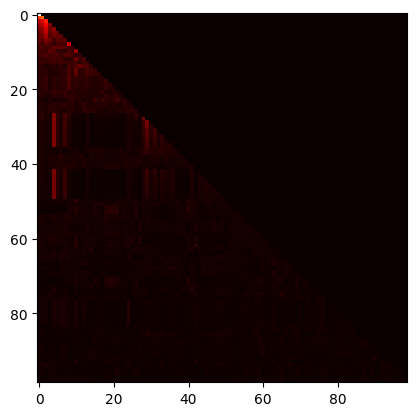

In [89]:
plt.imshow(att_weight[0], cmap='hot', interpolation='nearest')
plt.show()

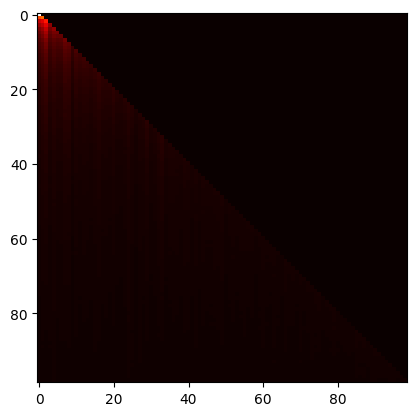

In [92]:
plt.imshow(torch.mean(att_weight, axis=0), cmap='hot', interpolation='nearest')
plt.show()

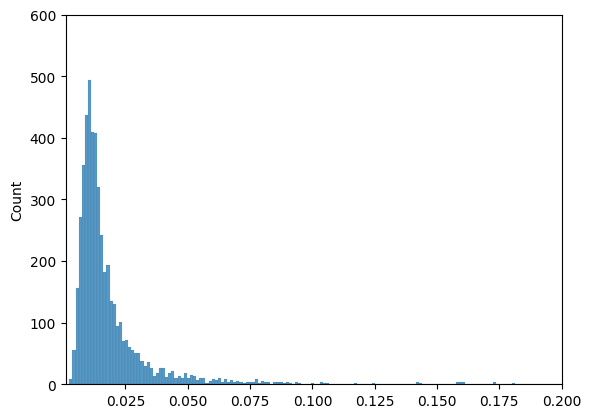

In [110]:
sns.histplot(att_weight[0].flatten())
plt.xlim(0.001,0.2)
plt.ylim(0,600)
plt.show()